# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
       
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """

In [3]:
def argmax_random_tiebreaking(a):
    max_a = np.where(a == max(a))[0]
    return np.random.choice(max_a)


## 1. Implement ε-greedy and UCB MABs

In [4]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        
        assert np.issubdtype(type(n_arms), np.integer) and n_arms > 0
        assert np.issubdtype(type(epsilon), np.floating) and epsilon >= 0 and epsilon <= 1
        assert np.issubdtype(type(Q0), np.floating)
           
        
        self.epsilon = epsilon
        self.n_arms = n_arms
        self.Q0 = Q0
        self.arm_means = np.ones(n_arms) * Q0
        self.arm_plays = np.ones(n_arms)
        
        
    
    def play(self, tround, context=None):
        super().play(context)
        
        assert np.issubdtype(type(tround), np.integer) and tround > 0
        
        prob = np.random.uniform(0,1)
        
        if prob <= self.epsilon:
            armplay = np.random.choice(self.n_arms)
        else:
            # Play arm with highest estimated reward
            armplay = argmax_random_tiebreaking(self.arm_means)
                    
        return armplay + 1
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        
        assert np.issubdtype(type(arm), np.integer) and arm <= self.n_arms and arm >= 1, "'arm' must be an int in the range [1, {}]".format(self.n_arms)
        assert np.issubdtype(type(reward), np.floating)
        
        arm = arm - 1
        # Update empirical arm reward mean with observed reward
        Q = self.arm_means[arm]
        N_arm = self.arm_plays[arm]
        
        if N_arm == 1:
            Q_update = reward
        else:
            Q_update = Q + 1 / N_arm * (reward - Q)
        
        self.arm_means[arm] = Q_update
        self.arm_plays[arm] = N_arm + 1

In [5]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        self.n_arms = n_arms
        self.rho = rho
        self.Q0 = Q0
        self.arm_means = np.ones(n_arms) * Q0
        self.arm_plays = np.ones(n_arms)
    
    def play(self, tround, context=None):
        super().play(context)
        arm_UCB = self.arm_means + np.sqrt(self.rho * np.log(tround) / self.arm_plays)
        armplay2 = argmax_random_tiebreaking(arm_UCB)
        
        return armplay2 + 1
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        arm = arm - 1
        # Update empirical arm reward mean with observed reward
        Q = self.arm_means[arm]
        N_arm = self.arm_plays[arm]
        
        if N_arm == 1:
            Q_update = reward
        else:
            Q_update = Q + 1 / N_arm * (reward - Q)
        
        self.arm_means[arm] = Q_update
        self.arm_plays[arm] = N_arm + 1

## 2. Implement off-policy evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # Check dtypes
    assert np.issubdtype(arms.dtype, np.integer)
    assert np.issubdtype(rewards.dtype, np.floating)
    assert np.issubdtype(contexts.dtype, np.floating)
    
    mab.tround = 0
    round_reward = list()
    for i in range(arms.size):
        if mab.tround >= n_rounds:
            return np.array(round_reward)
        arm = mab.play(mab.tround + 1, contexts[i])
        if arm - 1 == arms[i]:
            mab.update(arm, rewards[i], contexts[i])
            mab.tround += 1
            round_reward.append(rewards[i])
    return np.array(round_reward)


In [7]:
# load dataset here
dataset = np.genfromtxt('dataset.txt', dtype=np.int)
arms = dataset[:,0]
rewards = dataset[:,1].astype(float)
contexts = dataset[:,2::].astype(float)
trounds = 800

In [8]:
from collections import Counter
print(Counter(rewards))

Counter({0.0: 8961, 1.0: 1039})


In [9]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))
print('arm plays', mab.arm_plays)

EpsGreedy average reward 0.25625
arm plays [ 10. 736.   8.   5.   7.   8.   6.  12.  11.   7.]


In [10]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))
print('arm plays', mab.arm_plays)

UCB average reward 0.1775
arm plays [ 33. 197. 103.  46.  54.  54. 116.  33. 128.  46.]


## 3. Implement LinUCB contextual MAB

In [11]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        
        assert np.issubdtype(type(n_arms), np.integer) and n_arms > 0
        assert np.issubdtype(type(n_dims), np.integer) and n_dims > 0
        assert np.issubdtype(type(alpha), np.floating) and alpha > 0

        
        self.n_arms = n_arms
        self.n_dims = n_dims  
        self.alpha = alpha
        self.arms_A = np.stack([np.identity(self.n_dims) for _ in range(self.n_arms)])
        self.arms_b = np.stack([np.zeros(self.n_dims) for _ in range(self.n_arms)])
    
    def play(self, tround, context):
        super().play(context)
        assert np.issubdtype(type(tround), np.integer) and tround > 0
        
        context = context.reshape(self.n_arms, self.n_dims)
        arm_UCB = list()
        
        for arm in range(self.n_arms):
            
            x_a = context[arm]
            A_a = self.arms_A[arm]
            b_a = self.arms_b[arm]
            A_a_inv = np.linalg.inv(A_a)
            theta_a = A_a_inv @ b_a
            UCB_a = np.dot(theta_a, x_a) + self.alpha * np.sqrt(x_a.T @ A_a_inv @ x_a)
            arm_UCB.append(UCB_a)
            
        arm2play = argmax_random_tiebreaking(np.array(arm_UCB))

        return arm2play + 1
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        
        arm = arm - 1
        context = context.reshape(self.n_arms, self.n_dims)
        x_a = context[arm]
        self.arms_A[arm] = self.arms_A[arm] + np.outer(x_a, x_a)
        self.arms_b[arm] = self.arms_b[arm] + reward * x_a

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [13]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        
        assert np.issubdtype(type(n_arms), np.integer) and n_arms > 0
        assert np.issubdtype(type(n_dims), np.integer) and n_dims > 0
        
        self.n_arms = n_arms
        self.n_dims = n_dims 
        self.tree=[tree for _ in range(self.n_arms)]
        self.D=[None for i in range(self.n_arms)]
        self.P=[1 for i in range(self.n_arms)]
        
    def play(self, tround, context):
        super().play(context)
        assert np.issubdtype(type(tround), np.integer) and tround > 0

        p=list()
        
        for arm in range(self.n_arms):
            if self.D[arm] is not None:
                num_D=int(len(self.D[arm])/11)
                D_hat=np.random.randint(num_D,size=num_D)
                D_list=[]
                
                for i in D_hat:
                    D_list.append(self.D[arm][i*11:(i+1)*11])
                
                X=[]
                R=[]
                for i in range(num_D):
                    X.append(D_list[i][0:10])
                    R.append(D_list[i][10])
                    X_train=np.mat(X)
                    Y_train=np.array(R)
                
                self.tree[arm]=self.tree[arm].fit(X_train,Y_train)
                x_predict=context[arm*10:(arm+1)*10].reshape(1,10)
                self.P[arm]=self.tree[arm].predict(x_predict)
    
        for arm in range(self.n_arms):
            if self.P[arm]==max(self.P):
                p.append(arm)
                
        arm2play = np.asarray(p)
                
        return np.random.choice(arm2play) + 1
    
        
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        
        arm=arm-1
        context=context[arm*10:(arm+1)*10]
        if self.D[arm] is None:
            self.D[arm]=np.append(context,0)
            pair_1=np.append(context,1)
            self.D[arm]=np.concatenate((self.D[arm],pair_1))
        else:
            D_pair=np.append(context,reward)
            self.D[arm]=np.concatenate((self.D[arm],D_pair))
        

In [14]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.63625


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

EpsGreedy average reward 0.1525
UCB average reward 0.14875
LinUCB average reward 0.53
TreeBootstrap average reward 0.61625


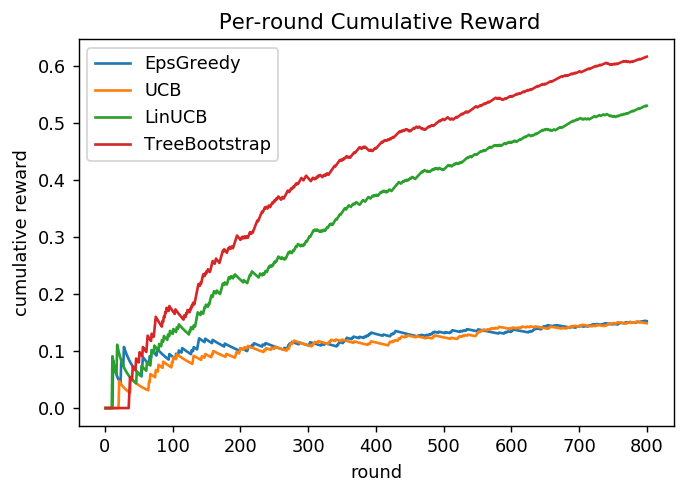

In [15]:
# Run offlineEvaluate on each of the bandits with the same hyperparameters
#EpsGreedy
mab_EpsGreedy = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab_EpsGreedy, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))
#UCB
mab_UCB = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab_UCB, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))
#LinUCB
mab_LinUCB = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab_LinUCB, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))
#TreeBootstrap
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))



def cumulative_reward(result):
    
    cumsum_result = np.cumsum(result)
    cumsum_result = [cumsum_result[i]/(i+1) for i in range(len(result))]
    return cumsum_result

#plotting
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

x_axis = [i for i in range(1,len(results_EpsGreedy)+1)]
plt.plot(x_axis,cumulative_reward(results_EpsGreedy),label="EpsGreedy")
x_axis = [i for i in range(1,len(results_UCB)+1)]
plt.plot(x_axis,cumulative_reward(results_UCB),label="UCB")
x_axis = [i for i in range(1,len(results_LinUCB)+1)]
plt.plot(x_axis,cumulative_reward(results_LinUCB),label="LinUCB")
x_axis = [i for i in range(1,len(results_TreeBootstrap)+1)]
plt.plot(x_axis,cumulative_reward(results_TreeBootstrap),label="TreeBootstrap")

plt.legend()
plt.title(' Per-round Cumulative Reward')
plt.xlabel('round')
plt.ylabel('cumulative reward')
plt.show()

### 5.B.

100%|██████████| 30/30 [01:19<00:00,  2.65s/it]


The Best alpha is 0.02395026619987486, and the corresponding reward is 0.7375


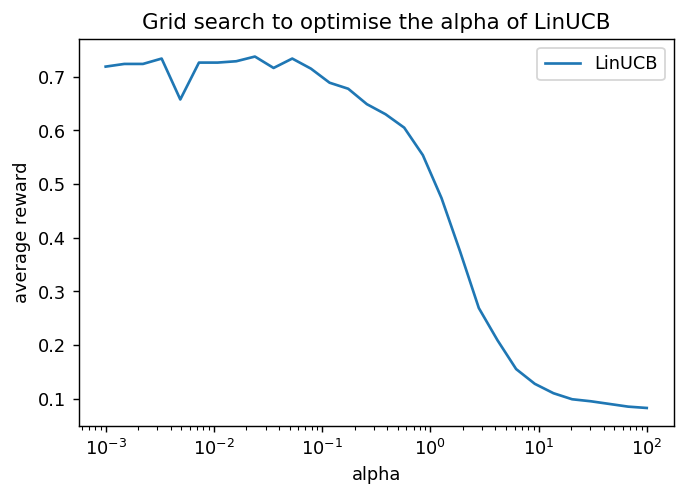

In [16]:
from tqdm import tqdm
alpha_range = np.logspace(-3, 2, num=30)

results = np.zeros(len(alpha_range))

#grid search
for i in tqdm(range(len(alpha_range))):
    mab = LinUCB(10, 10, alpha_range[i])
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results[i] = np.mean(results_LinUCB)
max_index = np.argmax(results)
print("The Best alpha is %s, and the corresponding reward is %s" %(alpha_range[max_index],results[max_index]))

#plotting
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

plt.title('Grid search to optimise the alpha of LinUCB')
plt.plot(alpha_range,results,label="LinUCB")

plt.legend()
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('average reward')
plt.show()

## 6. Implement KernelUCB contextual MAB

In [17]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        
        assert np.issubdtype(type(n_arms), np.integer) and n_arms > 0
        assert np.issubdtype(type(n_dims), np.integer) and n_dims > 0
        assert np.issubdtype(type(gamma), np.floating) and gamma > 0
        assert np.issubdtype(type(eta), np.floating) and eta > 0
        assert callable(kern)
        
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.Kinv = np.empty(0, dtype=float)
        self._rewards = np.zeros(0, dtype=float)
        self._contexts = np.zeros((0, n_dims), dtype=float)
        
    def play(self, tround, context):
        super().play(context)
        
        assert np.issubdtype(type(tround), np.integer) and tround > 0
        
        if tround > 1:
            context = np.reshape(context, newshape=(self.n_arms, -1))
            
            k_xx = self.kern(context).diagonal()
            k_x = self.kern(context, self._contexts)
            predictions = np.dot(k_x, self.Kinv @ self._rewards)
            variances = k_xx - np.sum(k_x.T * (self.Kinv @ k_x.T), axis=0)
            u = predictions + self.eta/(np.sqrt(self.gamma)) * np.sqrt(variances)
        else:
            u = np.zeros(self.n_arms)
            u[0] = 1
        
        return argmax_random_tiebreaking(u) + 1
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        
        assert np.issubdtype(type(arm), np.integer) and arm <= self.n_arms and arm >= 1
        assert np.issubdtype(type(reward), np.floating)
        
        arm0 = arm - 1
        context = np.reshape(context, newshape=(self.n_arms, -1))
        
        # Record history of reward, contexts
        self._rewards = np.append(self._rewards, reward)
        self._contexts = np.append(self._contexts, context[arm0, np.newaxis], axis=0)
        
        # Update Kinv
        k_x = self.kern(context, self._contexts)
        if k_x.shape[1] == 1:
            self.Kinv = 1/(k_x[arm0, np.newaxis] + self.gamma)
        else:
            b = k_x[arm0,0:-1]
            b_Kinv = b @ self.Kinv
            Kinv_b = self.Kinv @ b
            
            K22 = 1/(k_x[arm0,-1] + self.gamma - np.dot(b, Kinv_b))
            K11 = self.Kinv + K22 * np.outer(Kinv_b, b_Kinv)
            K12 = -K22 * Kinv_b[:,np.newaxis]
            K21 = -K22 * b_Kinv[np.newaxis]
            self.Kinv = np.block([[K11, K12], [K21, K22]])
            

In [18]:
mab = KernelUCB(10, 10, 1.0, 0.5, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.7075


LinUCB average reward 0.53
KernelUCB average reward 0.7525


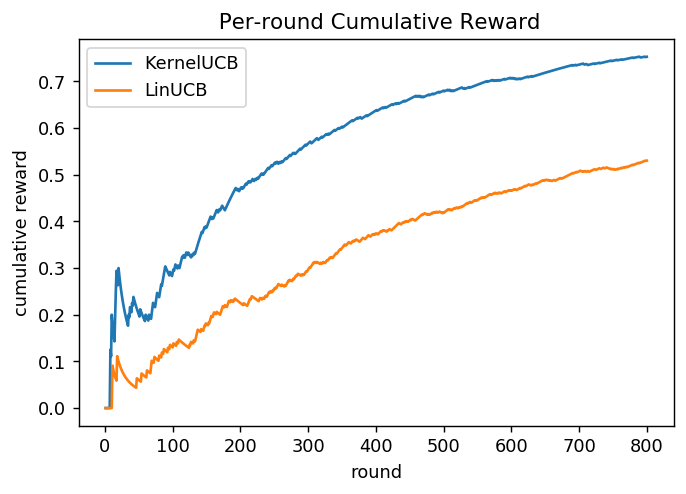

In [19]:
mab_LinUCB = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab_LinUCB, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

mab = KernelUCB(10, 10, 1.0, 0.5, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

#plot
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

x_axis = [i for i in range(1,len(results_KernelUCB)+1)]
plt.plot(x_axis,cumulative_reward(results_KernelUCB),label="KernelUCB")
x_axis = [i for i in range(1,len(results_LinUCB)+1)]
plt.plot(x_axis,cumulative_reward(results_LinUCB),label="LinUCB")


plt.legend()
plt.title(' Per-round Cumulative Reward')
plt.xlabel('round')
plt.ylabel('cumulative reward')
plt.show()